# Fly song

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import hdbscan
import deepss_unsupervised.event_utils
from io import BytesIO
import urllib.request

plt.style.use('ncb.mplstyle')

/Users/janc/miniconda/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/Users/janc/miniconda/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/Users/janc/miniconda/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'impl_ret_borrowed' requested from: 'numba.targets.imputils', please update to use 'numba.core

In [2]:
# import dss.utils, dss.utils_plot, dss.io, dss.data, dss.models, dss.predict, dss.train, dss.evaluate, dss.pulse_utils
# from scipy.ndimage import minimum_filter1d

# def fill_gaps(sine_pred, gap_dur=100):
#     onsets = np.where(np.diff(sine_pred.astype(np.int))==1)[0]
#     offsets = np.where(np.diff(sine_pred.astype(np.int))==-1)[0]
#     if len(onsets) and len(offsets):
#         onsets = onsets[onsets<offsets[-1]]
#         offsets = offsets[offsets>onsets[0]]
#         durations = offsets - onsets
#         for idx, (onset, offset, duration) in enumerate(zip(onsets, offsets, durations)):
#             if idx>0 and offsets[idx-1]>onsets[idx]-gap_dur:
#                 sine_pred[offsets[idx-1]:onsets[idx]+1] = 1
#     return sine_pred

# def remove_short(sine_pred, min_len=100):
#     # remove too short sine songs
#     onsets = np.where(np.diff(sine_pred.astype(np.int))==1)[0]
#     offsets = np.where(np.diff(sine_pred.astype(np.int))==-1)[0]
#     if len(onsets) and len(offsets):
#         onsets = onsets[onsets<offsets[-1]]
#         offsets = offsets[offsets>onsets[0]]
#         durations = offsets - onsets
#         for cnt, (onset, offset, duration) in enumerate(zip(onsets, offsets, durations)):
#             if duration<min_len:
#                 sine_pred[onset:offset+1] = 0
#     return sine_pred

# save_name = '/Volumes/shinkansen/Dropbox/dss.paper/models/dmel_all/20200507_173738' #20200426_172237'
# params = dss.utils.load_params(save_name)

# data = dss.io.load('/Volumes/shinkansen/Dropbox/dss.paper/dat/dmel_single_stern_raw.npy', y_suffix=params['y_suffix'])
# print(data['test']['x'].shape, data['test']['y'].shape, data['test']['y_pulse'].shape)
# samplerate = data.attrs['samplerate_x_Hz']

# model = dss.utils.load_model(save_name, dss.models.model_dict, from_epoch=False)
# x_test, y_test, y_pred = dss.evaluate.evaluate_probabilities(data['test']['x'], data['test']['y'], model, params, verbose=1)

# y_pred_pulse = y_pred[:, [0, 2]]
# y_pred_sine = y_pred[:, [0, 1]]

# labels_pred_pulse = dss.predict.labels_from_probabilities(y_pred_pulse, threshold=0.90)
# pulsetimes_pred, _ = dss.event_utils.detect_events(labels_pred_pulse, thres=0.90, min_dist=100)

# labels_pred_sine = dss.predict.labels_from_probabilities(y_pred_sine)
# labels_pred_sine = (labels_pred_sine>0).astype(np.float)

# gap_dur = 20 / 1000 * samplerate  # 20 ms
# labels_pred_sine = fill_gaps(labels_pred_sine, gap_dur)
# min_len = 20 / 1000 * samplerate  # 20 ms
# labels_pred_sine = remove_short(labels_pred_sine, min_len)

# win_hw = 100
# idx = minimum_filter1d(labels_pred_sine, size=2*win_hw)
# sinetimes_pred = np.where(idx)[0][::2*win_hw]

# recording=x_test
# pulse_times=pulsetimes_pred
# np.savez_compressed('data/flies.npz', 
#                     recording=x_test,
#                     pulsetimes=pulsetimes_pred,
#                     sinetimes=sinetimes_pred,
#                     samplerate=samplerate)

In [3]:
# data from D Stern (2014). Reported Drosophila courtship song rhythms are artifacts of data analysis. BMC Biology. https://www.janelia.org/lab/stern-lab/tools-reagents-data
url = 'https://github.com/janclemenslab/deepss_unsupervised/releases/download/v0.4/flies.npz'
with urllib.request.urlopen(url) as f:
    ff = BytesIO(f.read())

d = np.load(ff)
recording = d['recording']
pulsetimes = d['pulsetimes']
sinetimes = d['sinetimes']
samplerate = d['samplerate']

Pulses: (150, 356) sines: (150, 326) all: (150, 682)


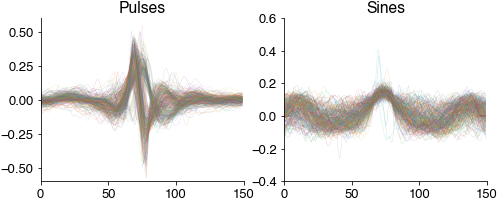

In [4]:
win_hw = 100
pulseshapes = deepss_unsupervised.event_utils.get_shapes(pulsetimes + win_hw, recording, win_hw)
pulseshapes = np.apply_along_axis(deepss_unsupervised.event_utils.normalize, axis=-1, arr=pulseshapes.T).T
pulseshapes = pulseshapes[25:-25]

sineshapes = deepss_unsupervised.event_utils.get_shapes(sinetimes + 2*win_hw, recording, win_hw)
sineshapes = np.apply_along_axis(deepss_unsupervised.event_utils.normalize, axis=-1, arr=sineshapes.T).T
sineshapes = sineshapes[25:-25]

good_shapes = np.sum((sineshapes==0).astype(np.float), axis=0)<10
sineshapes = sineshapes[:, good_shapes]

allshapes = np.concatenate((pulseshapes, sineshapes), axis=1)
print('Pulses:', pulseshapes.shape, 'sines:', sineshapes.shape, 'all:', allshapes.shape)
good_shapes = np.sum((sineshapes==0).astype(np.float), axis=0)<10
sineshapes = sineshapes[:, good_shapes]

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(pulseshapes, linewidth=0.5, alpha=0.2)
plt.title('Pulses')

plt.subplot(122)
plt.plot(sineshapes, linewidth=0.5, alpha=0.2)
plt.title('Sines')
plt.show()

In [5]:
out = umap.UMAP(min_dist=0.5).fit_transform(allshapes.T)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=20).fit_predict(out)

/Users/janc/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/janc/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/Users/janc/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes current

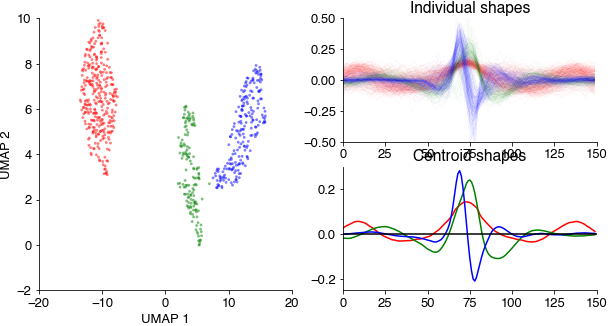

In [6]:
cols = 'rgb'

plt.figure(figsize=(10, 5))
for label in np.unique(hdbscan_labels):
    if label>=0:
        this = hdbscan_labels==label
        
        plt.subplot(121)
        plt.scatter(out[this,0], out[this,1], c=cols[label], s=8, alpha=0.5, edgecolor='none')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        
        plt.subplot(222)
        plt.plot(allshapes[:, this], c=cols[label], alpha=0.2, linewidth=0.1)
        plt.ylim(-0.5, 0.5)
        plt.title('Individual shapes')
        
        plt.subplot(224)
        plt.plot(np.mean(allshapes[:, this], axis=1), c=cols[label])
        plt.ylim(-0.25, 0.3)
        plt.title('Centroid shapes')
        
plt.axhline(0, c='k')
